# Trabalho No. 4

- Aluno: Guilherme Lisboa de Oliveira (GRR20170414)

```{admonition} Questões

O arquivo de dados http://leg.ufpr.br/~lucambio/CE017/20222S/paralytic-polio.csv contém informações anuais do número de casos e do número de mortes relatadas por poliomielite paralítica, nos Estados Unidos entre 1910 e 2019 com as seguintes variáveis:

**Entity** assume somente o valor United States

**Code** sempre USA

**Year** ano de informação, entre 1910 e 2019

**Cases** número de casos registrados

**Deaths** número de mortes anuais registradas por poliomielite

Analise o número de mortes relatadas por poliomielite paralítica, nos Estados Unidos, segundo o número de casos registrados.
```

In [1]:
import warnings
warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

Carregando os dados:

In [2]:
dados = pd.read_csv('./dados/paralytic-polio.csv', index_col='Year')
dados.index = pd.to_datetime(dados.index, format='%Y')
dados.index
dados

,Entity,Code,Cases,Deaths
Year,,,,
1910-01-01,United States,USA,5861,950.0
1911-01-01,United States,USA,1931,440.0
1913-01-01,United States,USA,1934,421.0
1914-01-01,United States,USA,1220,329.0
1915-01-01,United States,USA,1634,691.0
...,...,...,...,...
2015-01-01,United States,USA,0,0.0
2016-01-01,United States,USA,0,0.0
2017-01-01,United States,USA,0,0.0


Analisando tipos de variáveis:

In [3]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 109 entries, 1910-01-01 to 2019-01-01
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Entity  109 non-null    object 
 1   Code    109 non-null    object 
 2   Cases   109 non-null    int64  
 3   Deaths  104 non-null    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.3+ KB


Nota-se que **Deaths** contém dados faltantes e está definida como *float*. Como há poucas entradas, descartamos os dados faltantes e convertemos para *int*:

In [4]:
dados = dados.dropna()
dados.Deaths = pd.to_numeric(dados.Deaths, downcast='integer')

dados.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 104 entries, 1910-01-01 to 2019-01-01
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Entity  104 non-null    object
 1   Code    104 non-null    object
 2   Cases   104 non-null    int64 
 3   Deaths  104 non-null    int16 
dtypes: int16(1), int64(1), object(2)
memory usage: 3.5+ KB


In [5]:
dados.nunique()

Entity     1
Code       1
Cases     73
Deaths    64
dtype: int64

Vemos que **Entity** possui apenas "United States" como valor e **Code** também apenas "USA". Assim, descartamos estas variáveis:

In [6]:
dados = dados.drop(['Entity', 'Code'], axis=1)
dados

,Cases,Deaths
Year,,
1910-01-01,5861,950
1911-01-01,1931,440
1913-01-01,1934,421
1914-01-01,1220,329
1915-01-01,1634,691
...,...,...
2015-01-01,0,0
2016-01-01,0,0
2017-01-01,0,0


Para evitar problemas de ajuste, removemos os anos poucos casos:

In [7]:
número_mínimo_de_casos = 10
dados = dados[dados.Cases > número_mínimo_de_casos]

Para facilitar a vizualização da relação entre as variáveis restantes, plotamos **Cases** e **Deaths** ao longo da série:

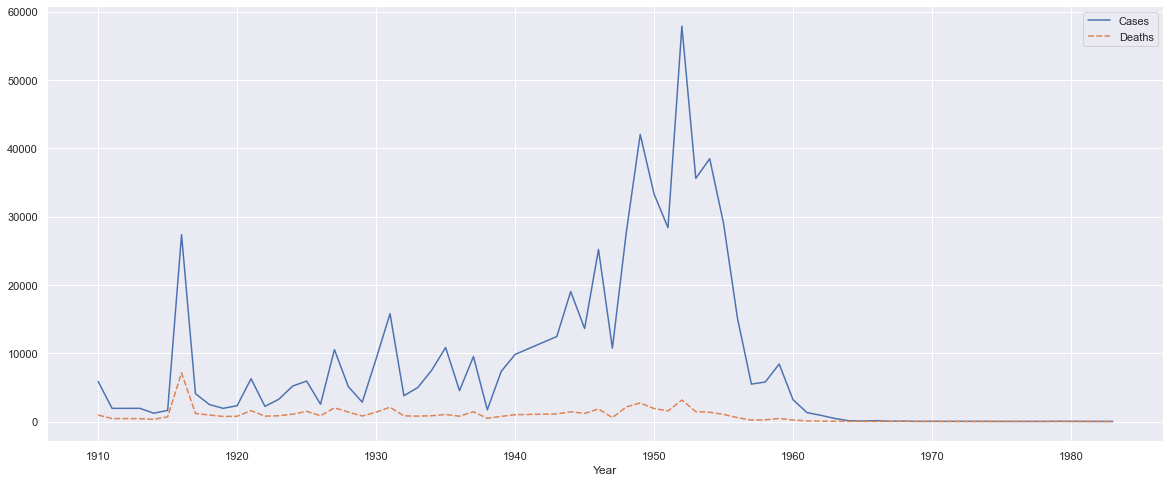

In [8]:
plt.figure(figsize=(20, 8))
sns.lineplot(data=dados[['Cases', 'Deaths']]);

Verificamos a auto-correlação da variável de interesse **Deaths**:

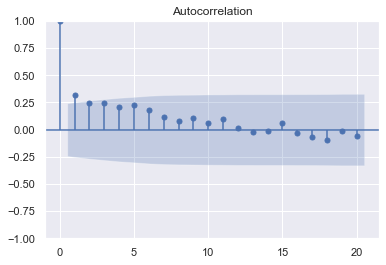

In [9]:
sm.graphics.tsa.plot_acf(dados.Deaths, lags=20);

Para mitigiar a auto-correlação, adicionamos variáveis de *lag*:

In [10]:
lags = 4

for lag in range(1, lags+1):
    dados[f'deaths_lag{lag}'] = np.maximum(0,np.log(dados.Deaths.shift(lag)))

dados.head(10)

,Cases,Deaths,deaths_lag1,deaths_lag2,deaths_lag3,deaths_lag4
Year,,,,,,
1910-01-01,5861,950,NaN,NaN,NaN,NaN
1911-01-01,1931,440,6.856462,NaN,NaN,NaN
1913-01-01,1934,421,6.086775,6.856462,NaN,NaN
1914-01-01,1220,329,6.042633,6.086775,6.856462,NaN
1915-01-01,1634,691,5.796058,6.042633,6.086775,6.856462
1916-01-01,27363,7130,6.538140,5.796058,6.042633,6.086775
1917-01-01,4082,1182,8.872067,6.538140,5.796058,6.042633
1918-01-01,2493,960,7.074963,8.872067,6.538140,5.796058
1919-01-01,1932,747,6.866933,7.074963,8.872067,6.538140


Então, removemos as primeiras linhas até a primeira observação com lags completos:

In [11]:
dados = dados.dropna()

Para melhorar o modelo, adicionamos informação externa sobre o início da vacinação contra polio nos Estados Unidos. Segundo o Centro de Controle de Doenças (CDC), a vacinação começou em 1955 (https://www.cdc.gov/polio/what-is-polio/polio-us.html). Adicionando uma variável indicativa de vacina disponível, temos:

In [12]:
máscara_vacina = (dados.index > '1955-01-01')
dados['Vacina'] = np.where(máscara_vacina, True, False)

Também adicionamos uma variável que indica o período de estabilidade de poucos casos:

In [13]:
máscara_estabilidade = (dados.index > '1965-01-01')
dados['Estabilidade'] = np.where(máscara_estabilidade, True, False)

Ajustando um modelo Poisson, temos:

In [14]:
offset = np.log(dados.Cases)

modelo = smf.glm(
    "Deaths ~ Vacina + Estabilidade + deaths_lag1 + deaths_lag2 + deaths_lag3 + deaths_lag4",
    data=dados,
    family=sm.families.Poisson(),
    offset=offset,
)

ajuste = modelo.fit()

ajuste.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 Deaths   No. Observations:                   61
Model:                            GLM   Df Residuals:                       54
Model Family:                 Poisson   Df Model:                            6
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -7996.2
Date:                Sun, 19 Feb 2023   Deviance:                       15530.
Time:                        16:42:04   Pearson chi2:                 2.08e+04
No. Iterations:                     8   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                5.1185      0.065     78.591      0.000       4.991       5.246
Vacina[T.True]          -1.4684      0.026    -55.866      0.000      -1.520      -1.417
Estabilidade[T.True]    -1.9336      0.093    -20.754      0.000      -2.116      -1.751
deaths_lag1             -0.2514      0.009    -28.771      0.000      -0.268      -0.234
deaths_lag2             -0.2323      0.008    -29.154      0.000      -0.248      -0.217
deaths_lag3             -0.3275      0.009    -37.714      0.000      -0.345      -0.310
deaths_lag4             -0.2345      0.009    -25.407      0.000      -0.253      -0.216
========================================================================================
"""

Verificando a capacidade predicitva, temos:

In [15]:
predicoes = ajuste.get_prediction(exog=dados[['Vacina', 'Estabilidade', 'deaths_lag1', 'deaths_lag2', 'deaths_lag3', 'deaths_lag4']], offset=offset)

resultados = dados.join(predicoes.summary_frame()).iloc[:, np.r_[0:2,8]]
resultados['mean'] = resultados['mean'].round().astype(int)
resultados.rename(columns={'mean': 'Predição Estimada'}, inplace=True)


resultados

,Cases,Deaths,Predição Estimada
Year,,,
1915-01-01,1634,691,427
1916-01-01,27363,7130,7628
1917-01-01,4082,1182,584
1918-01-01,2493,960,271
1919-01-01,1932,747,131
...,...,...,...
1976-01-01,14,16,10
1977-01-01,18,16,10
1978-01-01,15,13,9


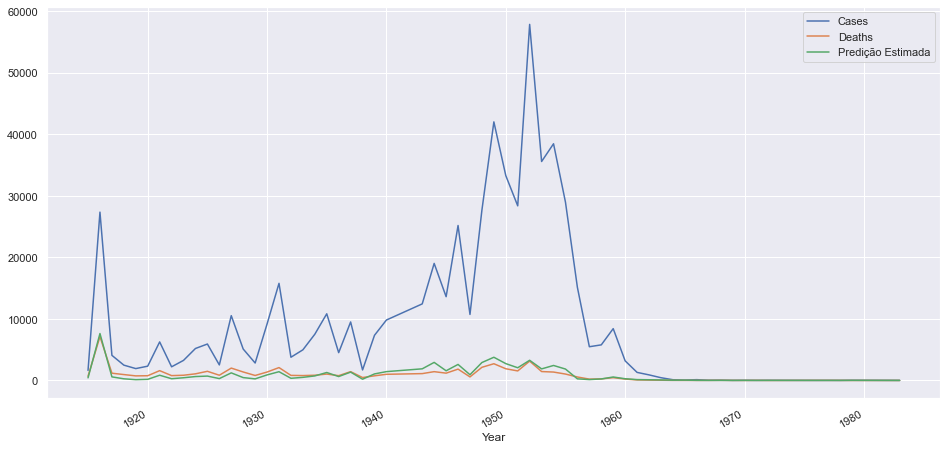

In [16]:
resultados.plot(figsize=(16,8));